# 개와 고양이 분류 (사전 학습 모델 VGG19 활용)

이 노트북은 사전 학습된 VGG19 모델을 사용하여 개와 고양이 이미지를 분류합니다. 
다음과 같은 **2단계 특성 추출(Two-Stage Feature Extraction)** 방식을 사용합니다:
1. **특성 추출**: VGG19의 합성곱 기반(Convolutional Base)을 사용하여 이미지에서 특성을 추출하고, 이 결과를 `.npy` 파일로 저장합니다.
2. **분류기 학습**: 저장된 특성을 입력으로 사용하여 새로운 소규모 완전 연결(Fully Connected) 분류기를 학습시킵니다.

## 1. 라이브러리 임포트

In [1]:
import os
import shutil
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, applications
import matplotlib.pyplot as plt

## 2. 데이터 준비

### 2.1. 데이터셋 다운로드 및 압축 해제

In [2]:
# Kaggle의 'Dogs vs. Cats' 원본 데이터셋 URL
dataset_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

# 데이터셋 다운로드 및 압축 해제
zip_path = tf.keras.utils.get_file(
    'kagglecatsanddogs.zip',
    origin=dataset_url,
    extract=True
)

# 원본 데이터 경로 설정 (PetImages 폴더 안에 Cat, Dog 폴더가 있음)
original_dir = pathlib.Path(zip_path).parent / 'PetImages'
print(f"원본 데이터 경로: {original_dir}")

824887076/824887076 [==============================] - 76s 0us/step
원본 데이터 경로: C:\Users\Admin\.keras\datasets\PetImages


### 2.2. 손상된 이미지 제거

In [3]:
# 일부 이미지가 손상되어 있어 학습 오류를 유발할 수 있으므로 제거합니다.
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = original_dir / folder_name
    for fname in os.listdir(folder_path):
        fpath = folder_path / fname
        try:
            # 파일 헤더를 확인하여 유효한 이미지인지 검사
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # 손상된 파일 삭제
            os.remove(fpath)

print(f"손상된 이미지 {num_skipped}개를 삭제했습니다.")

손상된 이미지 1578개를 삭제했습니다.


### 2.3. 훈련/검증/테스트용 서브셋 생성

In [5]:
new_base_dir = pathlib.Path("./cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("Cat", "Dog"):
        # 서브셋 디렉토리 생성 (e.g., ./cats_vs_dogs_small/train/Cat)
        dir = new_base_dir / subset_name / category
        if not dir.exists():
            os.makedirs(dir)
        
        # 원본 디렉토리에서 파일 이름 목록 생성
        fnames = [f for f in os.listdir(original_dir / category)]
        # 지정된 범위의 파일만 선택
        selected_fnames = fnames[start_index:end_index]
        
        for fname in selected_fnames:
            shutil.copyfile(src=original_dir / category / fname, dst=dir / fname)
    print(f"'{subset_name}' 서브셋 생성 완료.")

# 이미 서브셋이 존재하면 다시 생성하지 않음
if not new_base_dir.exists():
    make_subset("train", start_index=0, end_index=1000)
    make_subset("validation", start_index=1000, end_index=1500)
    make_subset("test", start_index=1500, end_index=2000)
else:
    print("서브셋 디렉토리가 이미 존재합니다.")

'train' 서브셋 생성 완료.
'validation' 서브셋 생성 완료.
'test' 서브셋 생성 완료.


## 3. 사전 학습된 모델(VGG19) 로드

In [6]:
conv_base = applications.vgg19.VGG19(
    weights="imagenet",      # ImageNet으로 사전 학습된 가중치 사용
    include_top=False,       # 분류기(Fully Connected Layer)는 제외하고 합성곱 기반만 로드
    input_shape=(180, 180, 3) # 입력 이미지 크기 지정
)

# VGG19의 합성곱 기반은 학습되지 않도록 동결
conv_base.trainable = False

print("VGG19 합성곱 기반 모델 요약:")
conv_base.summary()



80134624/80134624 [==============================] - 8s 0us/step
VGG19 합성곱 기반 모델 요약:
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                        

## 4. 특성 추출 (Feature Extraction)

### 4.1. 데이터셋 로더 생성

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMAGE_SIZE = (180, 180)

train_ds = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
validation_ds = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
test_ds = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### 4.2. VGG19를 이용한 특성 및 레이블 추출

In [8]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        # VGG19 모델에 맞는 전처리 적용
        preprocessed_images = applications.vgg19.preprocess_input(images)
        # conv_base를 통해 특성 추출
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    # 리스트를 하나의 넘파이 배열로 결합
    return np.concatenate(all_features), np.concatenate(all_labels)

print("훈련 데이터에서 특성을 추출합니다...")
train_features, train_labels = get_features_and_labels(train_ds)
print("검증 데이터에서 특성을 추출합니다...")
validation_features, validation_labels = get_features_and_labels(validation_ds)
print("테스트 데이터에서 특성을 추출합니다...")

test_features, test_labels = get_features_and_labels(test_ds)

print("\n추출된 훈련 특성의 형태:", train_features.shape)

훈련 데이터에서 특성을 추출합니다...
검증 데이터에서 특성을 추출합니다...
테스트 데이터에서 특성을 추출합니다...

추출된 훈련 특성의 형태: (2000, 5, 5, 512)


## 5. 분류기 모델 정의 및 학습

**참고**: 원본 스크립트의 데이터 증강(Data Augmentation)은 특성 맵(`5x5x512`)에 적용되어 오류를 유발하므로 여기서는 제외했습니다. 데이터 증강은 원본 이미지(`180x180x3`)에 적용되어야 합니다. 올바른 방식은 `conv_base`와 새로운 분류기를 하나의 모델로 합친 후, 이미지 데이터셋을 직접 학습시키는 것입니다(인라인 방식).

In [9]:
# VGG19의 출력 형태(5, 5, 512)를 입력으로 받는 새로운 분류기 모델 정의
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x) # 이진 분류 (개/고양이)
model = keras.Model(inputs, outputs)

# 모델 컴파일
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# 가장 성능이 좋은 모델을 저장하기 위한 콜백 설정
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_model.keras",
        save_best_only=True,      # 가장 좋은 모델만 저장
        monitor="val_loss"        # 검증 손실을 기준으로 판단
    )
]

# 모델 학습
history = model.fit(
    train_features, train_labels,
    epochs=20, # 에포크 수를 20으로 늘려 충분히 학습
    validation_data=(validation_features, validation_labels),
    callbacks=callbacks
)


Epoch 1/20


63/63 [==============================] - 2s 21ms/step - loss: 5.8020 - accuracy: 0.9080 - val_loss: 0.9361 - val_accuracy: 0.9650
Epoch 2/20
63/63 [==============================] - 1s 17ms/step - loss: 0.6899 - accuracy: 0.9700 - val_loss: 1.0798 - val_accuracy: 0.9530
Epoch 3/20
63/63 [==============================] - 1s 17ms/step - loss: 0.4795 - accuracy: 0.9765 - val_loss: 1.1152 - val_accuracy: 0.9510
Epoch 4/20
63/63 [==============================] - 1s 18ms/step - loss: 0.2309 - accuracy: 0.9885 - val_loss: 0.7833 - val_accuracy: 0.9710
Epoch 5/20
63/63 [==============================] - 1s 19ms/step - loss: 0.1629 - accuracy: 0.9910 - val_loss: 0.6246 - val_accuracy: 0.9770
Epoch 6/20
63/63 [==============================] - 1s 17ms/step - loss: 0.0594 - accuracy: 0.9945 - val_loss: 0.9001 - val_accuracy: 0.9630
Epoch 7/20
63/63 [==============================] - 1s 17ms/step - loss: 0.0805 - accuracy: 0.9945 - val_loss: 0.8037 - val_accuracy: 0.9760
Epoch 8/20

## 6. 학습 결과 시각화

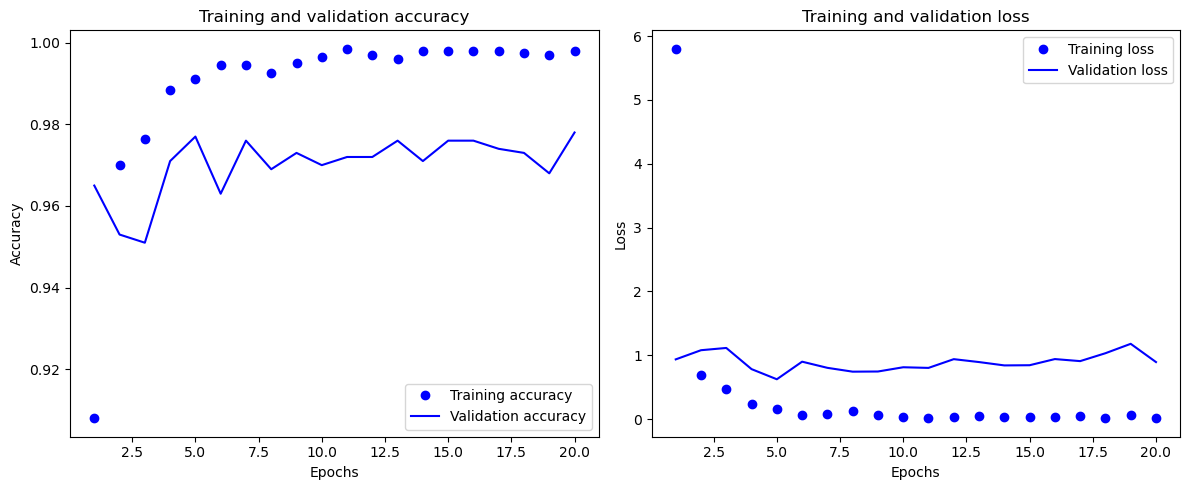

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 7. 모델 평가 (테스트 데이터)

In [11]:
# 저장된 최적의 모델을 로드
best_model = keras.models.load_model("feature_extraction_model.keras")

print("테스트 데이터셋으로 최종 모델을 평가합니다...")
test_loss, test_acc = best_model.evaluate(test_features, test_labels)
print(f'테스트 정확도: {test_acc*100:.2f}%')

테스트 데이터셋으로 최종 모델을 평가합니다...
32/32 [==============================] - 0s 2ms/step - loss: 0.6066 - accuracy: 0.9840
테스트 정확도: 98.40%
